<a href="https://colab.research.google.com/github/am3lia-low/battle-of-BERTS-FOMC/blob/main/FOMC_Step2_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FOMC Hawkish-Dovish Classification — Step 2: FinBERT vs RoBERTa Training
## DSA4265 Take-Home Assignment

This notebook covers:
1. Training **FinBERT** (financial domain pre-trained BERT) on FOMC hawkish-dovish classification
2. Training **RoBERTa-large** (the original paper's best model) for comparison
3. Comprehensive evaluation: confusion matrices, ROC curves, per-class metrics
4. Error analysis and model comparison
5. Analysis by year/era

**Models:**
- `yiyanghkust/finbert-pretrain` — BERT pre-trained on financial communications (110M params)
- `roberta-large` — General-purpose language model (355M params)

**Research Question:** Can financial domain pre-training (FinBERT, 110M params) outperform a larger general-purpose model (RoBERTa, 355M params) on monetary policy stance classification?

---

## 1. Setup

In [ ]:
!pip install transformers datasets accelerate scikit-learn matplotlib seaborn -q

In [ ]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
)
from sklearn.preprocessing import label_binarize
from scipy.special import softmax

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    # print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_mem / 1e9:.1f} GB")
else:
    print("WARNING: No GPU. Go to Runtime > Change runtime type > GPU")

Device: cuda
GPU: Tesla T4


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
DRIVE_PATH = '/content/drive/MyDrive/Colab Notebooks/'

df_train = pd.read_csv(DRIVE_PATH + 'train.csv')
df_val = pd.read_csv(DRIVE_PATH + 'val.csv')
df_test = pd.read_csv(DRIVE_PATH + 'test.csv')

LABEL_MAP = {0: 'Dovish', 1: 'Hawkish', 2: 'Neutral'}
NUM_LABELS = 3

print(f"Train: {len(df_train):,}  Val: {len(df_val):,}  Test: {len(df_test):,}")
print(f"\nTrain label distribution:")
print(df_train['label'].map(LABEL_MAP).value_counts().to_string())

Mounted at /content/drive
Train: 1,686  Val: 298  Test: 496

Train label distribution:
label
Neutral    830
Dovish     438
Hawkish    418


## 2. Dataset & Tokenization

In [ ]:
from torch.utils.data import Dataset

class FOMCDataset(Dataset):
    """Dataset for FOMC hawkish-dovish classification."""
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            str(self.texts[idx]),
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

print("Dataset class defined.")

Dataset class defined.


## 3. Training Helper Functions

In [ ]:
from transformers import TrainingArguments, Trainer

def compute_metrics(eval_pred):
    """Compute metrics for Hugging Face Trainer."""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(labels, predictions)
    prec, rec, f1, _ = precision_recall_fscore_support(labels, predictions, average='macro')
    probs = softmax(logits, axis=1)
    labels_bin = label_binarize(labels, classes=[0, 1, 2])
    try:
        auc_score = roc_auc_score(labels_bin, probs, multi_class='ovr', average='macro')
    except ValueError:
        auc_score = 0.0
    return {'accuracy': accuracy, 'precision_macro': prec, 'recall_macro': rec,
            'f1_macro': f1, 'auc_macro': auc_score}


def train_and_evaluate(model_name, tokenizer_name, output_name, num_epochs=5,
                       learning_rate=2e-5, batch_size=16, max_length=128):
    """Train a model and return evaluation results."""
    from transformers import AutoTokenizer, AutoModelForSequenceClassification

    print(f"\n{'='*60}")
    print(f"TRAINING: {output_name}")
    print(f"  Model: {model_name}")
    print(f"  Epochs: {num_epochs}, LR: {learning_rate}, Batch: {batch_size}")
    print(f"{'='*60}")

    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, num_labels=NUM_LABELS
    ).to(device)

    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"  Total params: {total_params:,}")
    print(f"  Trainable params: {trainable_params:,}")

    # Create datasets
    train_dataset = FOMCDataset(df_train['sentence'].values, df_train['label'].values,
                                tokenizer, max_length)
    val_dataset = FOMCDataset(df_val['sentence'].values, df_val['label'].values,
                              tokenizer, max_length)
    test_dataset = FOMCDataset(df_test['sentence'].values, df_test['label'].values,
                               tokenizer, max_length)

    # Training arguments
    training_args = TrainingArguments(
        output_dir=DRIVE_PATH + f'{output_name}_checkpoints',
        num_train_epochs=num_epochs,
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=32,
        weight_decay=0.01,
        warmup_ratio=0.1,
        eval_strategy='epoch',
        save_strategy='epoch',
        load_best_model_at_end=True,
        metric_for_best_model='f1_macro',
        greater_is_better=True,
        logging_steps=50,
        seed=42,
        fp16=True,
        report_to='none',
    )

    trainer = Trainer(
        model=model, args=training_args,
        train_dataset=train_dataset, eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
    )

    # Train
    train_result = trainer.train()
    print(f"  Training time: {train_result.metrics['train_runtime']:.0f}s")
    print(f"  Training loss: {train_result.metrics['train_loss']:.4f}")

    # Evaluate on test set
    predictions_output = trainer.predict(test_dataset)
    logits = predictions_output.predictions
    y_true = predictions_output.label_ids
    y_pred = np.argmax(logits, axis=-1)
    y_probs = softmax(logits, axis=1)

    # Compute all metrics
    accuracy = accuracy_score(y_true, y_pred)
    prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
    y_true_bin = label_binarize(y_true, classes=[0, 1, 2])
    auc_macro = roc_auc_score(y_true_bin, y_probs, multi_class='ovr', average='macro')

    print(f"\n  TEST RESULTS:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  F1 Macro:  {f1_macro:.4f}")
    print(f"  AUC Macro: {auc_macro:.4f}")

    # Save model
    save_path = DRIVE_PATH + f'{output_name}_model'
    trainer.save_model(save_path)
    tokenizer.save_pretrained(save_path)

    # Collect training history
    log_history = trainer.state.log_history

    results = {
        'model_name': model_name,
        'output_name': output_name,
        'total_params': total_params,
        'trainable_params': trainable_params,
        'accuracy': accuracy,
        'precision_macro': prec_macro,
        'recall_macro': rec_macro,
        'f1_macro': f1_macro,
        'auc_macro': auc_macro,
        'y_true': y_true,
        'y_pred': y_pred,
        'y_probs': y_probs,
        'y_true_bin': y_true_bin,
        'log_history': log_history,
        'training_time': train_result.metrics['train_runtime'],
    }

    # Free GPU memory
    del model, trainer
    torch.cuda.empty_cache()

    return results

print("Training helper function defined.")

Training helper function defined.


## 4. Train FinBERT

`yiyanghkust/finbert-pretrain` is a BERT-base model further pre-trained on a large corpus of
financial communications including corporate reports, earnings call transcripts, and analyst reports.

We fine-tune it on the FOMC hawkish-dovish task — a novel application since FinBERT was never
trained on central bank language specifically. This tests whether financial domain knowledge
transfers to monetary policy text.

In [ ]:
finbert_results = train_and_evaluate(
    model_name='yiyanghkust/finbert-pretrain',
    tokenizer_name='yiyanghkust/finbert-pretrain',
    output_name='finbert',
    num_epochs=5,
    learning_rate=2e-5,
    batch_size=16,
    max_length=128
)


TRAINING: finbert
  Model: yiyanghkust/finbert-pretrain
  Epochs: 5, LR: 2e-05, Batch: 16


config.json:   0%|          | 0.00/359 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

BertForSequenceClassification LOAD REPORT from: yiyanghkust/finbert-pretrain
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider t

  Total params: 109,754,115
  Trainable params: 109,754,115


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Auc Macro
1,0.957728,0.874347,0.600671,0.594289,0.534977,0.534539,0.768162
2,0.730524,0.844666,0.593960,0.577233,0.583251,0.573711,0.795391
3,0.487754,0.863468,0.671141,0.651337,0.629572,0.637640,0.810469
4,0.265033,1.039812,0.664430,0.637744,0.640344,0.638775,0.803910
5,0.183240,1.119587,0.661074,0.632124,0.631191,0.631389,0.801624


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La

  Training time: 128s
  Training loss: 0.5323



  TEST RESULTS:
  Accuracy:  0.6512
  F1 Macro:  0.6331
  AUC Macro: 0.8201


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

## 5. Train RoBERTa-large

`roberta-large` was the best-performing model in the original Shah et al. (2023) paper.
It's a general-purpose language model with 355M parameters — over 3x the size of FinBERT.

This serves as our benchmark: can FinBERT's domain knowledge compensate for RoBERTa's
larger size and broader pre-training?

In [ ]:
roberta_results = train_and_evaluate(
    model_name='roberta-large',
    tokenizer_name='roberta-large',
    output_name='roberta',
    num_epochs=5,
    learning_rate=1e-5,  # Lower LR for larger model
    batch_size=8,         # Smaller batch for larger model (GPU memory)
    max_length=128
)


TRAINING: roberta
  Model: roberta-large
  Epochs: 5, LR: 1e-05, Batch: 8


config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/389 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: roberta-large
Key                             | Status     | 
--------------------------------+------------+-
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
lm_head.dense.bias              | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
lm_head.dense.weight            | UNEXPECTED | 
classifier.dense.bias           | MISSING    | 
classifier.out_proj.bias        | MISSING    | 
classifier.dense.weight         | MISSING    | 
classifier.out_proj.weight      | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


  Total params: 355,362,819
  Trainable params: 355,362,819


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Auc Macro
1,0.991372,1.154181,0.553691,0.524913,0.456300,0.445730,0.720311
2,0.761130,0.760349,0.681208,0.660323,0.672999,0.664901,0.843208
3,0.544981,0.757190,0.741611,0.718862,0.730482,0.723383,0.870218
4,0.430004,0.792905,0.755034,0.735075,0.731306,0.733070,0.874232
5,0.204831,0.957542,0.748322,0.727423,0.730894,0.728742,0.872867


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Could not locate the best model at /content/drive/MyDrive/Colab Notebooks/roberta_checkpoints/checkpoint-844/pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.


  Training time: 973s
  Training loss: 0.6040



  TEST RESULTS:
  Accuracy:  0.7258
  F1 Macro:  0.7102
  AUC Macro: 0.8698


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

## 6. Head-to-Head Model Comparison

In [ ]:
# Summary table
print("MODEL COMPARISON — TEST SET")
print("=" * 70)
print(f"{'Metric':<20} {'FinBERT':<15} {'RoBERTa-large':<15} {'Difference':<15}")
print("-" * 70)

metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'auc_macro']
metric_names = ['Accuracy', 'Precision (M)', 'Recall (M)', 'F1 Score (M)', 'AUC-ROC (M)']

for metric, name in zip(metrics, metric_names):
    fb = finbert_results[metric]
    rb = roberta_results[metric]
    diff = fb - rb
    winner = "FinBERT" if diff > 0 else "RoBERTa"
    print(f"  {name:<20} {fb:<15.4f} {rb:<15.4f} {diff:+.4f} ({winner})")

print(f"\n  {'Parameters':<20} {finbert_results['total_params']:>13,} {roberta_results['total_params']:>13,}")
print(f"  {'Training Time':<20} {finbert_results['training_time']:>12.0f}s {roberta_results['training_time']:>12.0f}s")

MODEL COMPARISON — TEST SET
Metric               FinBERT         RoBERTa-large   Difference     
----------------------------------------------------------------------
  Accuracy             0.6512          0.7258          -0.0746 (RoBERTa)
  Precision (M)        0.6333          0.7064          -0.0731 (RoBERTa)
  Recall (M)           0.6454          0.7164          -0.0710 (RoBERTa)
  F1 Score (M)         0.6331          0.7102          -0.0771 (RoBERTa)
  AUC-ROC (M)          0.8201          0.8698          -0.0497 (RoBERTa)

  Parameters             109,754,115   355,362,819
  Training Time                 128s          973s


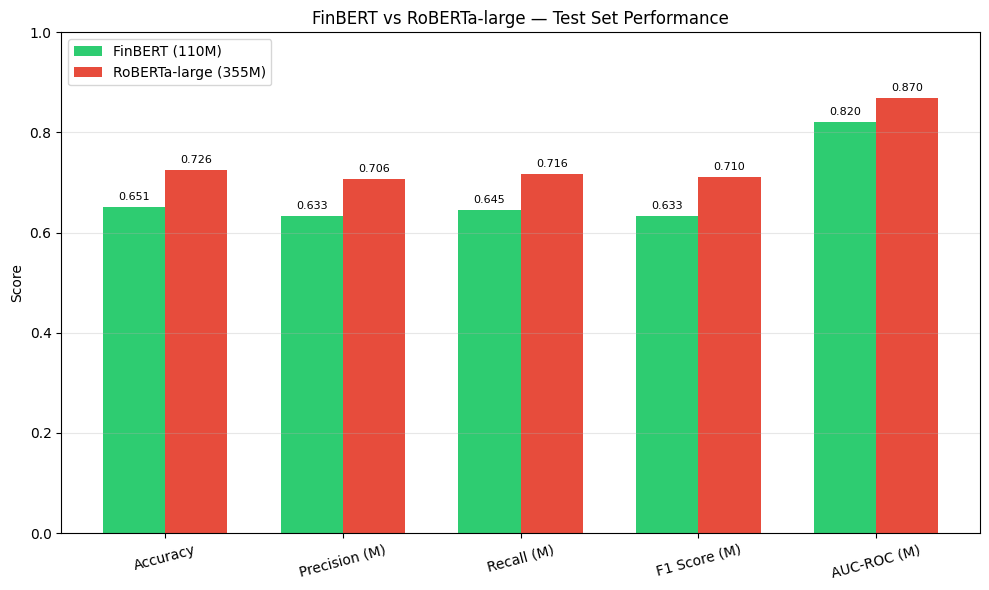

In [ ]:
# Bar chart comparison
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(metric_names))
width = 0.35

fb_scores = [finbert_results[m] for m in metrics]
rb_scores = [roberta_results[m] for m in metrics]

bars1 = ax.bar(x - width/2, fb_scores, width, label='FinBERT (110M)', color='#2ecc71')
bars2 = ax.bar(x + width/2, rb_scores, width, label='RoBERTa-large (355M)', color='#e74c3c')

ax.set_ylabel('Score')
ax.set_title('FinBERT vs RoBERTa-large — Test Set Performance')
ax.set_xticks(x)
ax.set_xticklabels(metric_names, rotation=15)
ax.legend()
ax.set_ylim(0, 1)
ax.grid(True, alpha=0.3, axis='y')

for bars in [bars1, bars2]:
    for bar in bars:
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
                f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig(DRIVE_PATH + 'model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Confusion Matrices

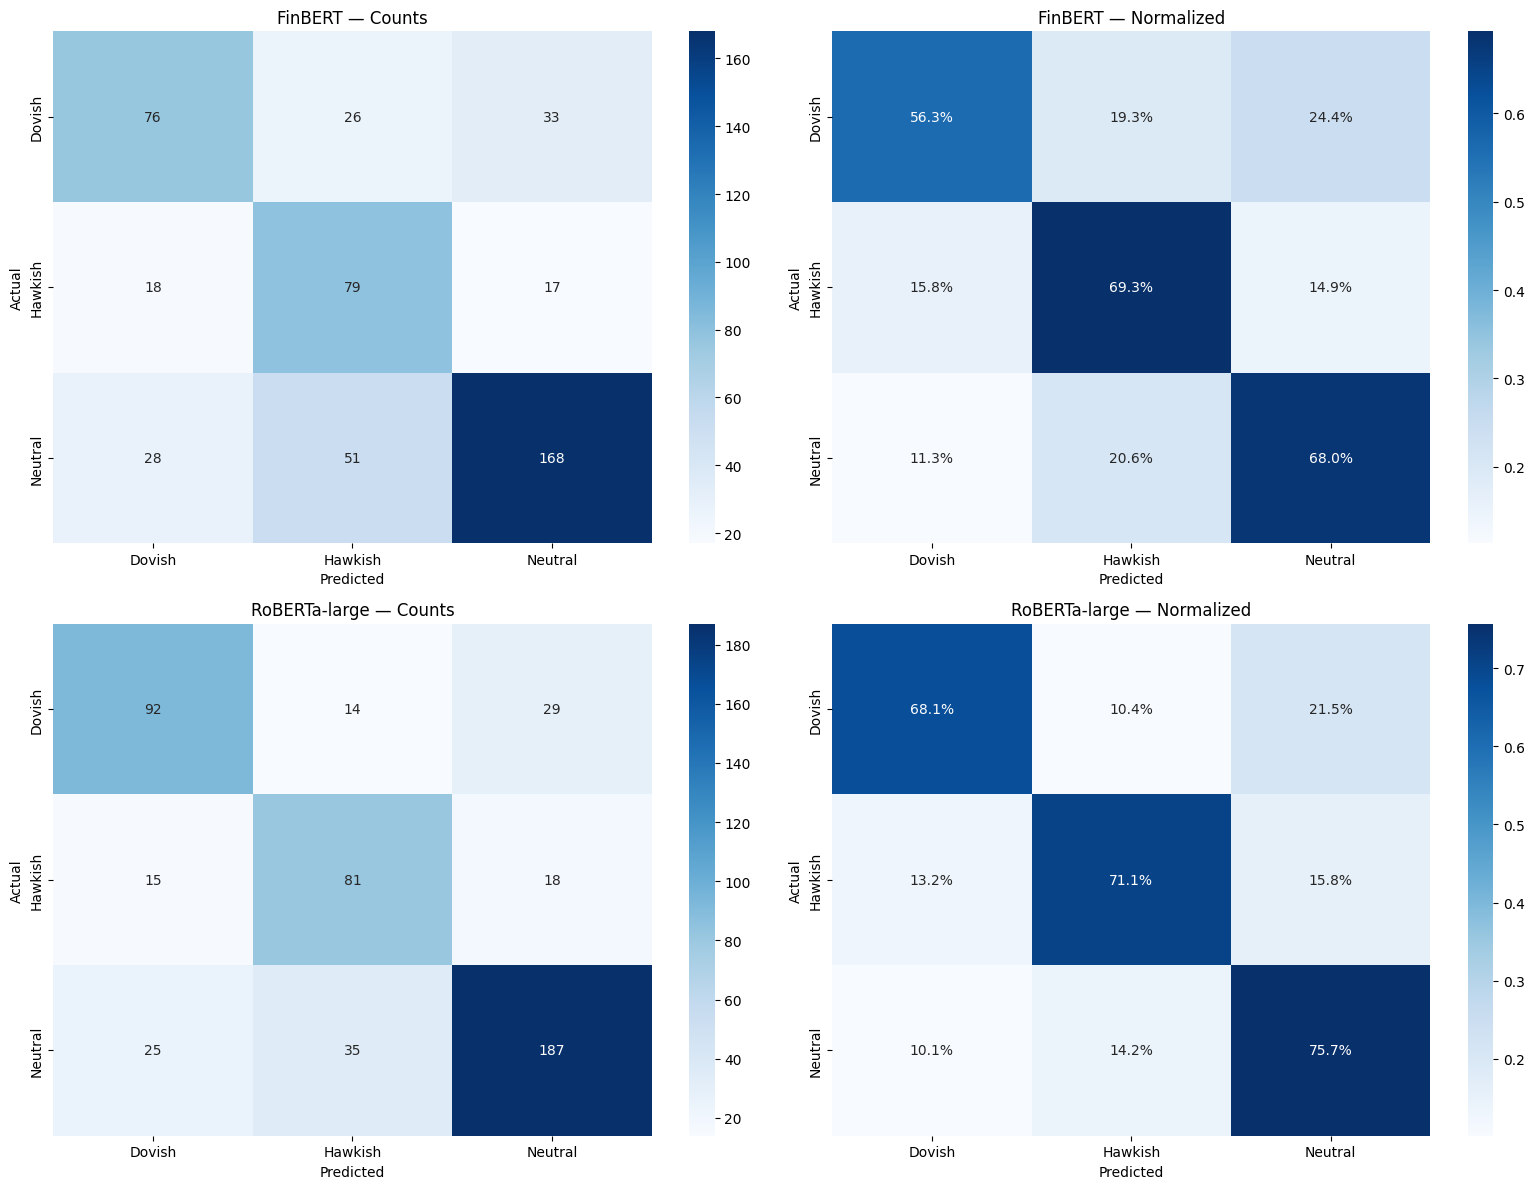


FinBERT — CLASSIFICATION REPORT
              precision    recall  f1-score   support

      Dovish     0.6230    0.5630    0.5914       135
     Hawkish     0.5064    0.6930    0.5852       114
     Neutral     0.7706    0.6802    0.7226       247

    accuracy                         0.6512       496
   macro avg     0.6333    0.6454    0.6331       496
weighted avg     0.6697    0.6512    0.6553       496


RoBERTa-large — CLASSIFICATION REPORT
              precision    recall  f1-score   support

      Dovish     0.6970    0.6815    0.6891       135
     Hawkish     0.6231    0.7105    0.6639       114
     Neutral     0.7991    0.7571    0.7775       247

    accuracy                         0.7258       496
   macro avg     0.7064    0.7164    0.7102       496
weighted avg     0.7309    0.7258    0.7274       496



In [ ]:
label_names = ['Dovish', 'Hawkish', 'Neutral']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for idx, (results, name) in enumerate([(finbert_results, 'FinBERT'), (roberta_results, 'RoBERTa-large')]):
    # Raw counts
    cm = confusion_matrix(results['y_true'], results['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx][0],
                xticklabels=label_names, yticklabels=label_names)
    axes[idx][0].set_xlabel('Predicted')
    axes[idx][0].set_ylabel('Actual')
    axes[idx][0].set_title(f'{name} — Counts')

    # Normalized
    cm_norm = confusion_matrix(results['y_true'], results['y_pred'], normalize='true')
    sns.heatmap(cm_norm, annot=True, fmt='.1%', cmap='Blues', ax=axes[idx][1],
                xticklabels=label_names, yticklabels=label_names)
    axes[idx][1].set_xlabel('Predicted')
    axes[idx][1].set_ylabel('Actual')
    axes[idx][1].set_title(f'{name} — Normalized')

plt.tight_layout()
plt.savefig(DRIVE_PATH + 'confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

# Per-class detailed report
for results, name in [(finbert_results, 'FinBERT'), (roberta_results, 'RoBERTa-large')]:
    print(f"\n{name} — CLASSIFICATION REPORT")
    print("=" * 60)
    print(classification_report(results['y_true'], results['y_pred'],
                               target_names=label_names, digits=4))

## 8. ROC Curves

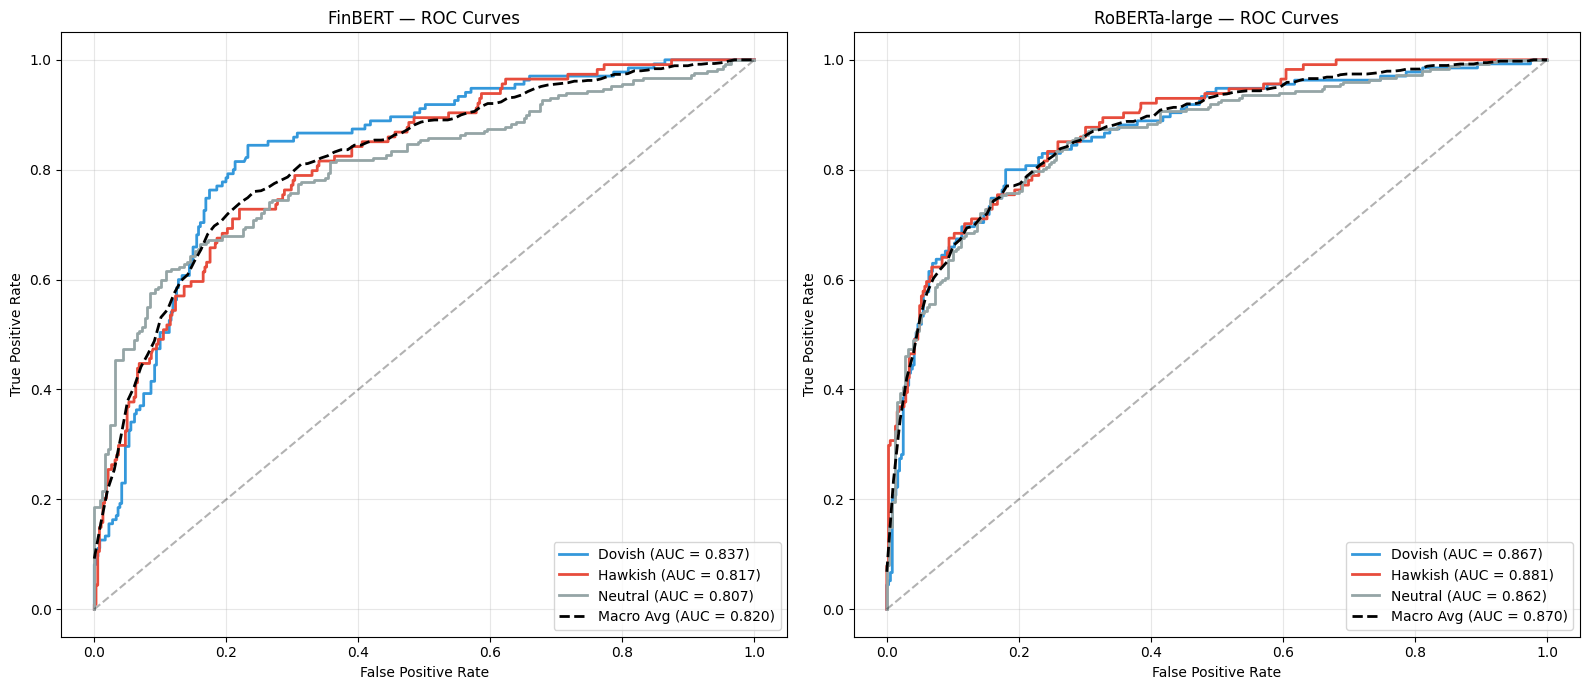

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
colors_roc = ['#3498db', '#e74c3c', '#95a5a6']

for ax, (results, name) in zip(axes, [(finbert_results, 'FinBERT'), (roberta_results, 'RoBERTa-large')]):
    for i, (label, color) in enumerate(zip(label_names, colors_roc)):
        fpr, tpr, _ = roc_curve(results['y_true_bin'][:, i], results['y_probs'][:, i])
        roc_auc_val = auc(fpr, tpr)
        ax.plot(fpr, tpr, color=color, linewidth=2,
                label=f'{label} (AUC = {roc_auc_val:.3f})')

    # Macro average
    all_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(NUM_LABELS):
        fpr, tpr, _ = roc_curve(results['y_true_bin'][:, i], results['y_probs'][:, i])
        mean_tpr += np.interp(all_fpr, fpr, tpr)
    mean_tpr /= NUM_LABELS
    ax.plot(all_fpr, mean_tpr, 'k--', linewidth=2,
            label=f'Macro Avg (AUC = {results["auc_macro"]:.3f})')
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.3)

    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'{name} — ROC Curves')
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(DRIVE_PATH + 'roc_curves.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Training Dynamics

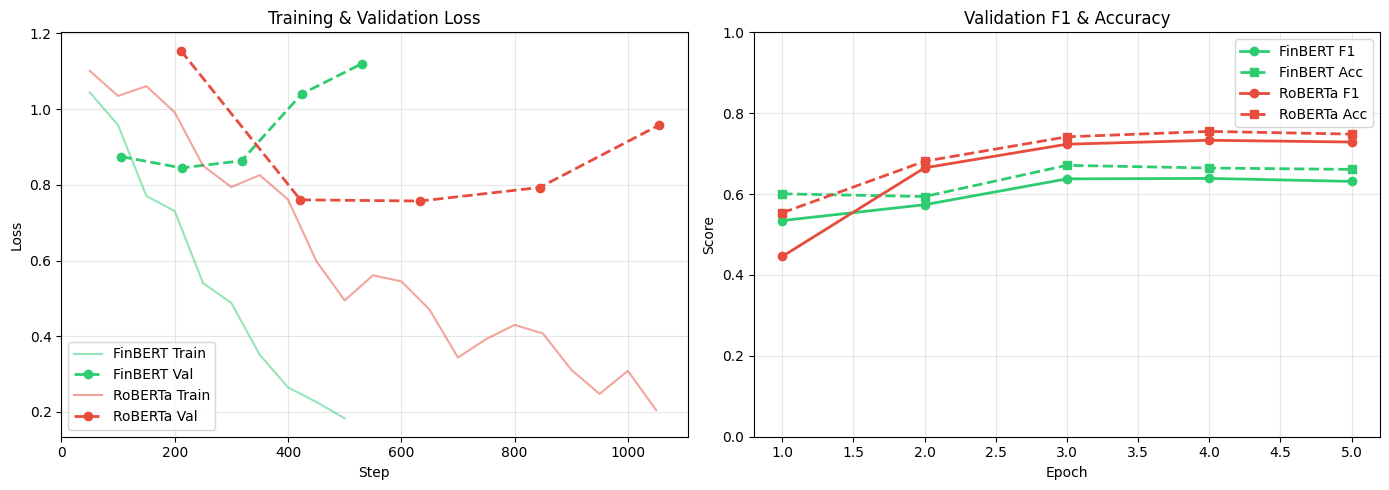

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for results, name, color in [(finbert_results, 'FinBERT', '#2ecc71'),
                              (roberta_results, 'RoBERTa', '#e74c3c')]:
    log = results['log_history']
    train_logs = [x for x in log if 'loss' in x and 'eval_loss' not in x]
    eval_logs = [x for x in log if 'eval_loss' in x]

    # Loss curves
    axes[0].plot([x['step'] for x in train_logs], [x['loss'] for x in train_logs],
                 alpha=0.5, color=color, label=f'{name} Train')
    axes[0].plot([x['step'] for x in eval_logs], [x['eval_loss'] for x in eval_logs],
                 marker='o', linewidth=2, color=color, linestyle='--', label=f'{name} Val')

    # F1 curves
    epochs = list(range(1, len(eval_logs) + 1))
    axes[1].plot(epochs, [x['eval_f1_macro'] for x in eval_logs],
                 marker='o', linewidth=2, color=color, label=f'{name} F1')
    axes[1].plot(epochs, [x['eval_accuracy'] for x in eval_logs],
                 marker='s', linewidth=2, color=color, linestyle='--', label=f'{name} Acc')

axes[0].set_xlabel('Step'); axes[0].set_ylabel('Loss')
axes[0].set_title('Training & Validation Loss'); axes[0].legend(); axes[0].grid(True, alpha=0.3)

axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Score')
axes[1].set_title('Validation F1 & Accuracy'); axes[1].legend(); axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.savefig(DRIVE_PATH + 'training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

## 10. Error Analysis

Where do the models disagree? Where does one succeed and the other fail?

In [ ]:
# Build error analysis dataframe
df_errors = df_test.copy()
df_errors['finbert_pred'] = finbert_results['y_pred']
df_errors['roberta_pred'] = roberta_results['y_pred']
df_errors['finbert_correct'] = df_errors['label'] == df_errors['finbert_pred']
df_errors['roberta_correct'] = df_errors['label'] == df_errors['roberta_pred']

# Agreement between models
both_correct = (df_errors['finbert_correct'] & df_errors['roberta_correct']).sum()
both_wrong = (~df_errors['finbert_correct'] & ~df_errors['roberta_correct']).sum()
finbert_only = (df_errors['finbert_correct'] & ~df_errors['roberta_correct']).sum()
roberta_only = (~df_errors['finbert_correct'] & df_errors['roberta_correct']).sum()

print("MODEL AGREEMENT ANALYSIS")
print("=" * 50)
print(f"  Both correct:    {both_correct:>4}  ({both_correct/len(df_errors)*100:.1f}%)")
print(f"  Both wrong:      {both_wrong:>4}  ({both_wrong/len(df_errors)*100:.1f}%)")
print(f"  FinBERT only:    {finbert_only:>4}  ({finbert_only/len(df_errors)*100:.1f}%)")
print(f"  RoBERTa only:    {roberta_only:>4}  ({roberta_only/len(df_errors)*100:.1f}%)")

MODEL AGREEMENT ANALYSIS
  Both correct:     286  (57.7%)
  Both wrong:        99  (20.0%)
  FinBERT only:      37  (7.5%)
  RoBERTa only:      74  (14.9%)


In [ ]:
# Examples where FinBERT succeeds but RoBERTa fails
fb_wins = df_errors[df_errors['finbert_correct'] & ~df_errors['roberta_correct']]
print(f"FINBERT CORRECT, RoBERTa WRONG ({len(fb_wins)} cases)")
print("=" * 80)
for _, row in fb_wins.head(5).iterrows():
    true_label = LABEL_MAP[row['label']]
    rb_label = LABEL_MAP[row['roberta_pred']]
    print(f"  True: {true_label:<10} RoBERTa: {rb_label:<10}")
    print(f"  [{row['year']}] {row['sentence'][:120]}...")
    print()

# Examples where RoBERTa succeeds but FinBERT fails
rb_wins = df_errors[~df_errors['finbert_correct'] & df_errors['roberta_correct']]
print(f"\nRoBERTa CORRECT, FinBERT WRONG ({len(rb_wins)} cases)")
print("=" * 80)
for _, row in rb_wins.head(5).iterrows():
    true_label = LABEL_MAP[row['label']]
    fb_label = LABEL_MAP[row['finbert_pred']]
    print(f"  True: {true_label:<10} FinBERT: {fb_label:<10}")
    print(f"  [{row['year']}] {row['sentence'][:120]}...")
    print()

# Examples where BOTH fail
both_fail = df_errors[~df_errors['finbert_correct'] & ~df_errors['roberta_correct']]
print(f"\nBOTH WRONG ({len(both_fail)} cases)")
print("=" * 80)
for _, row in both_fail.head(5).iterrows():
    true_label = LABEL_MAP[row['label']]
    fb_label = LABEL_MAP[row['finbert_pred']]
    rb_label = LABEL_MAP[row['roberta_pred']]
    print(f"  True: {true_label:<10} FinBERT: {fb_label:<10} RoBERTa: {rb_label:<10}")
    print(f"  [{row['year']}] {row['sentence'][:120]}...")
    print()

FINBERT CORRECT, RoBERTa WRONG (37 cases)
  True: Neutral    RoBERTa: Dovish    
  [2020] A few participants judged that while the labor market was close to full employment, some margins of slack remained; thes...

  True: Neutral    RoBERTa: Dovish    
  [2004] Even so, most members viewed a slowing to a rate closer to most estimates of the growth of the economy's potential as a ...

  True: Hawkish    RoBERTa: Neutral   
  [1998] Inflation targeting was also associated with increased communication and transparency designed to clarify the central ba...

  True: Neutral    RoBERTa: Hawkish   
  [2012] She showed there some so-called optimal policy rules that come from trying to get the best possible outcomes from our qu...

  True: Dovish     RoBERTa: Neutral   
  [2006] The Summary of Economic Projections by FOMC participants in December 2020 had the unemployment rate moving down to 4.2 p...


RoBERTa CORRECT, FinBERT WRONG (74 cases)
  True: Neutral    FinBERT: Hawkish   
  [2004] Pa

## 11. Performance by Monetary Policy Era

Does model accuracy vary across different monetary policy regimes?
- **Pre-GFC (1996–2007):** Greenspan era, rate hikes, dot-com bubble
- **GFC & Recovery (2008–2015):** Zero rates, QE, forward guidance
- **Normalization (2016–2019):** Gradual rate hikes
- **COVID & Inflation (2020–2022):** Emergency cuts, then aggressive hikes

PERFORMANCE BY ERA
Era                    N      FinBERT Acc    RoBERTa Acc    Gap       
----------------------------------------------------------------------
  Pre-GFC                244    0.676          0.758          -0.082
  GFC & Recovery         91     0.670          0.736          -0.066
  Normalization          77     0.584          0.662          -0.078
  COVID & Inflation      84     0.619          0.679          -0.060


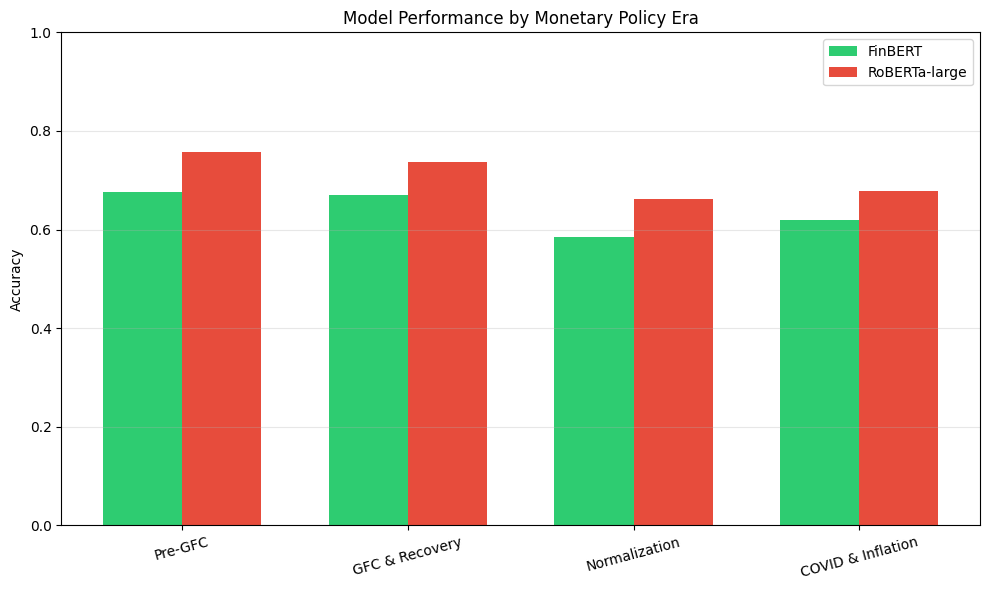

In [ ]:
def assign_era(year):
    if year <= 2007: return 'Pre-GFC'
    elif year <= 2015: return 'GFC & Recovery'
    elif year <= 2019: return 'Normalization'
    else: return 'COVID & Inflation'

df_errors['era'] = df_errors['year'].apply(assign_era)

print("PERFORMANCE BY ERA")
print("=" * 70)
print(f"{'Era':<22} {'N':<6} {'FinBERT Acc':<14} {'RoBERTa Acc':<14} {'Gap':<10}")
print("-" * 70)

era_results = {}
for era in ['Pre-GFC', 'GFC & Recovery', 'Normalization', 'COVID & Inflation']:
    mask = df_errors['era'] == era
    if mask.sum() > 0:
        fb_acc = df_errors.loc[mask, 'finbert_correct'].mean()
        rb_acc = df_errors.loc[mask, 'roberta_correct'].mean()
        gap = fb_acc - rb_acc
        era_results[era] = {'n': mask.sum(), 'finbert': fb_acc, 'roberta': rb_acc}
        print(f"  {era:<22} {mask.sum():<6} {fb_acc:<14.3f} {rb_acc:<14.3f} {gap:+.3f}")

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
eras = list(era_results.keys())
x = np.arange(len(eras))
width = 0.35
ax.bar(x - width/2, [era_results[e]['finbert'] for e in eras], width,
       label='FinBERT', color='#2ecc71')
ax.bar(x + width/2, [era_results[e]['roberta'] for e in eras], width,
       label='RoBERTa-large', color='#e74c3c')
ax.set_ylabel('Accuracy')
ax.set_title('Model Performance by Monetary Policy Era')
ax.set_xticks(x)
ax.set_xticklabels(eras, rotation=15)
ax.legend()
ax.set_ylim(0, 1)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(DRIVE_PATH + 'performance_by_era.png', dpi=150, bbox_inches='tight')
plt.show()

## 12. Save All Results

In [ ]:
# Save comprehensive results
all_results = {
    'finbert': {
        'model': 'yiyanghkust/finbert-pretrain',
        'params': finbert_results['total_params'],
        'accuracy': float(finbert_results['accuracy']),
        'precision_macro': float(finbert_results['precision_macro']),
        'recall_macro': float(finbert_results['recall_macro']),
        'f1_macro': float(finbert_results['f1_macro']),
        'auc_macro': float(finbert_results['auc_macro']),
        'training_time_s': float(finbert_results['training_time']),
    },
    'roberta': {
        'model': 'roberta-large',
        'params': roberta_results['total_params'],
        'accuracy': float(roberta_results['accuracy']),
        'precision_macro': float(roberta_results['precision_macro']),
        'recall_macro': float(roberta_results['recall_macro']),
        'f1_macro': float(roberta_results['f1_macro']),
        'auc_macro': float(roberta_results['auc_macro']),
        'training_time_s': float(roberta_results['training_time']),
    }
}

with open(DRIVE_PATH + 'evaluation_results.json', 'w') as f:
    json.dump(all_results, f, indent=2)
print(f"Results saved to: {DRIVE_PATH}evaluation_results.json")

# Save error analysis
df_errors.to_csv(DRIVE_PATH + 'error_analysis.csv', index=False)
print(f"Error analysis saved to: {DRIVE_PATH}error_analysis.csv")

print("\n" + "=" * 60)
print("ALL DONE!")
print("=" * 60)
print(f"\nFinBERT:  Acc={finbert_results['accuracy']:.4f}  F1={finbert_results['f1_macro']:.4f}  AUC={finbert_results['auc_macro']:.4f}")
print(f"RoBERTa:  Acc={roberta_results['accuracy']:.4f}  F1={roberta_results['f1_macro']:.4f}  AUC={roberta_results['auc_macro']:.4f}")
print("\nReady for report writing!")

Results saved to: /content/drive/MyDrive/Colab Notebooks/evaluation_results.json
Error analysis saved to: /content/drive/MyDrive/Colab Notebooks/error_analysis.csv

ALL DONE!

FinBERT:  Acc=0.6512  F1=0.6331  AUC=0.8201
RoBERTa:  Acc=0.7258  F1=0.7102  AUC=0.8698

Ready for report writing!


## 13. Summary

### Models Trained
1. **FinBERT** (`yiyanghkust/finbert-pretrain`) — 110M params, financial domain pre-training
2. **RoBERTa-large** (`roberta-large`) — 355M params, general-purpose, original paper's best model

### Research Question
Can FinBERT's financial domain knowledge compensate for RoBERTa's 3x larger size on monetary policy stance classification?

### Key Outputs
- `model_comparison.png` — head-to-head metric comparison
- `confusion_matrices.png` — per-model confusion matrices
- `roc_curves.png` — ROC curves for both models
- `training_curves.png` — loss and metric convergence
- `performance_by_era.png` — accuracy across monetary policy regimes
- `evaluation_results.json` — all metrics
- `error_analysis.csv` — per-sentence predictions for analysis

### Next Step
- **Step 3:** Write the report